## Model Developer Workflow Example

### Using czbenchmarks to evaluate an in-development model on a single task

This notebook demonstrates how to leverage the czbenchmarks library to generate benchmark metrics for a previously published model (using existing model weights) and integrate czbenchmarks into the developer workflow for iterative evaluation of model performance during parameter tuning.

We focus on the `Cell Clustering` task as an example, but the same approach can be applied to other tasks supported by `czbenchmarks`. For a comprehensive overview of all tasks, refer to the `scvi_all_task_sbenchmark.ipynb` notebook.

In this example, we use scVI, a popular tool for single-cell analysis, to compare the performance of published model weights against variations obtained through iterative re-training. 

> **NOTE**: This workflow can also be adapted for the development and evaluation of entirely new models.

### Key Highlights:
- **Benchmark Metrics**: Evaluate clustering performance using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).
- **Iterative Development**: Demonstrate how to fine-tune model parameters and assess performance improvements.
- **Generalization**: Showcase how the workflow can be extended to other tasks and models.

### Step 1: Setup and Imports

To begin, ensure your environment is properly configured. This includes setting up a virtual environment, installing required dependencies, and registering the environment as a Jupyter kernel. Below is the setup process:

#### Virtual Environment Setup (Optional)
If you need to create a new virtual environment, uncomment and run the commands in cell below


In [1]:
# # Create isolated virtual environment for scVI and czbenchmarks (run once)

# !python3 -m venv .venv_scvi

# # Install model required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools matplotlib seaborn

# # Register the new environment as a Jupyter kernel (if not already registered)
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment '.venv_scvi' created, dependencies installed, and kernel registered.")


#### Import Libraries

This notebook requires the following libraries:

- **czbenchmarks**: For dataset loading and task evaluation.
- **scVI**: For model inference and fine-tuning.
- **Visualization tools**: For plotting benchmark results (matplotlib, seaborn, pandas).

In [2]:
from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset
from czbenchmarks.tasks import ClusteringTask
from czbenchmarks.tasks.clustering import ClusteringTaskInput

import scvi
import functools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
sns.set_theme(style="whitegrid")

### Step 2: Load and Prepare the Dataset


In this step, we load the pre-configured `tsv2_prostate` dataset, which is specifically designed for single-cell analysis tasks. The `czbenchmarks` library simplifies this process by automatically handling dataset download, caching, and loading as a `SingleCellLabeledDataset`.

### Key Features:
- **Gene Expression Data (`dataset.adata`)**: AnnData object with gene expression matrices and metadata.
- **Cell Type Labels (`dataset.labels`)**: A pandas Series containing cell type annotations, which serve as ground truth for benchmarking tasks like clustering and label prediction.

---

> **NOTE**: Always verify that dataset is compatible with the model input requirements before running inference.

In [3]:
dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")
dataset.adata
dataset.labels

INFO:czbenchmarks.file_utils:File already exists in cache: /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad
INFO:czbenchmarks.datasets.single_cell:Loading dataset from /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad in memory mode.


TSP25_Prostate_NA_10X_1_1_AAACCCAAGTGGTTAA                       endothelial cell
TSP25_Prostate_NA_10X_1_1_AAACCCACATGCACTA    luminal cell of prostate epithelium
TSP25_Prostate_NA_10X_1_1_AAACGAAGTTCTGACA                       endothelial cell
TSP25_Prostate_NA_10X_1_1_AAACGCTTCTACCCAC                            erythrocyte
TSP25_Prostate_NA_10X_1_1_AAAGAACCAGTTGTCA                     smooth muscle cell
                                                             ...                 
TSP25_Prostate_NA_10X_1_2_TTTATGCTCTTGGTCC                             fibroblast
TSP25_Prostate_NA_10X_1_2_TTTCACAAGATCGGTG      basal cell of prostate epithelium
TSP25_Prostate_NA_10X_1_2_TTTCACAGTGCCTTCT                             fibroblast
TSP25_Prostate_NA_10X_1_2_TTTCATGCAATAGTAG        CD8-positive, alpha-beta T cell
TSP25_Prostate_NA_10X_1_2_TTTCCTCAGGTGATCG                             fibroblast
Name: cell_type, Length: 2044, dtype: category
Categories (14, object): ['fibroblast', 'T cell', '

#### Optionally Transform Data

After loading the dataset, you may need to transform the data to meet the requirements of your model.

In [4]:
# Prepare the dataset for scVI model
adata = dataset.adata.copy()
required_obs_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, [adata.obs[c].astype(str) for c in required_obs_keys]
)

### Step 3: Obtain Pre-trained Model, Run Model Inference, and Generate Output

In this step, we leverage the pre-trained scVI model to generate cell embeddings for evaluation within the benchmarking framework. The pre-trained model weights serve as a reference point for comparison against fine-tuned or newly developed model variants.

---

> **NOTE**: For your own model, adapt the loading and inference steps to match your model's requirements. 

#### Load Pre-trained Model Weights

In [5]:
import os
import boto3


def download_scvi_weights(local_model_dir="czbenchmarks_scvi_model"):
    if not os.path.exists(local_model_dir):
        os.makedirs(local_model_dir, exist_ok=True)
    if not os.listdir(local_model_dir):
        s3 = boto3.client("s3")
        bucket_name = "cz-benchmarks-data"
        prefix = "models/v1/scvi_2023_12_15/homo_sapiens/"
        print("Downloading model weights from S3...")
        paginator = s3.get_paginator("list_objects_v2")
        for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
            for obj in page.get("Contents", []):
                key = obj["Key"]
                if key.endswith("/"):
                    continue
                local_path = os.path.join(local_model_dir, os.path.relpath(key, prefix))
                os.makedirs(os.path.dirname(local_path), exist_ok=True)
                s3.download_file(bucket_name, key, local_path)
        print(f"Downloaded model weights to {local_model_dir}\n")
    return local_model_dir


model_weights_dir = download_scvi_weights()

#### Generate Embeddings with Pre-trained Model

Extract cell embeddings (latent representations) from the model, which will be used for downstream benchmarking tasks.

In [6]:
scvi.model.SCVI.prepare_query_anndata(adata, model_weights_dir)
scvi_model = scvi.model.SCVI.load_query_data(adata, model_weights_dir)
scvi_model.is_trained = True
scvi_output_embedding = scvi_model.get_latent_representation()
print(f"Generated scVI embedding with shape: {scvi_output_embedding.shape}")

INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
INFO     Found 44.05% reference vars in query data.                                                                
INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
Generated scVI embedding with shape: (2044, 50)


### Step 4: Clustering Task Evaluation

Evaluate the quality of embeddings generated by pre-trained and fine-tuned scVI models using the `ClusteringTask` from `czbenchmarks`. Metrics include:

- **Adjusted Rand Index (ARI)**: Measures similarity between predicted clusters and ground truth labels.
- **Normalized Mutual Information (NMI)**: Quantifies mutual dependence between predicted clusters and ground truth labels.

Higher ARI and NMI scores indicate better clustering performance.

In [ ]:
# Utility function to run clustering task
def run_clustering_benchmark(cell_representation, obs, labels):
    task = ClusteringTask()
    task_input = ClusteringTaskInput(input_labels=labels)
    results = task.run(cell_representation=cell_representation, task_input=task_input)
    return {r.metric_type: r.value for r in results}

#### Pre-trained Model Evaluation

Benchmark the clustering performance of the embeddings generated by the pre-trained scVI model.

In [8]:
benchmark_results = {}

# Pre-trained scVI
benchmark_results["scvi_pretrained"] = run_clustering_benchmark(
    scvi_output_embedding, dataset.adata.obs, dataset.labels
)

#### Baseline Comparison

Compute clustering metrics for a baseline method (e.g., PCA) to establish a reference point for comparison.

In [9]:
baseline_embedding = ClusteringTask().compute_baseline(dataset.adata.X)
benchmark_results["pca_baseline"] = run_clustering_benchmark(
    baseline_embedding, dataset.adata.obs, dataset.labels
)

#### Iterative Model Evaluation

Extend the workflow to evaluate clustering performance for fine-tuned or newly developed model variants.

In [10]:
# Function to fine-tune the scVI model
def fine_tune_scvi_model(adata, n_latent=10, max_epochs=10):
    model = scvi.model.SCVI(adata, n_latent=n_latent)
    model.train(
        max_epochs=max_epochs,
        plan_kwargs={"lr": 0.0005},
        early_stopping=True,
        early_stopping_patience=10,
    )
    return model

**Demonstrating Iterative Model Evaluation and Hyperparameter Tuning with czbenchmarks**

In this section, we demonstrate how `czbenchmarks` supports iterative model evaluation and hyperparameter tuning within a development workflow. By leveraging the `fine_tune_model` function, we simulate the process of updating model parameters—such as varying the latent dimension (`n_latent`)—and assess the impact on clustering performance.

**Workflow Overview:**
1. **Generate Model Variants:** Create multiple scVI model versions by adjusting key parameters (e.g., `n_latent`).
2. **Fine-Tune Each Variant:** Train each model variant using the scVI training API with custom configurations.
3. **Evaluate Performance:** Apply `czbenchmarks` to compute clustering metrics (ARI, NMI) for each variant, enabling direct comparison and informed parameter selection.


In [11]:
# Fine-tuned scVI variants
for n_latent in [3, 5, 10, 25]:
    tuned_model = fine_tune_scvi_model(adata, n_latent=n_latent)
    tuned_embedding = tuned_model.get_latent_representation()
    key = f"scvi_n_latent_{n_latent}"
    benchmark_results[key] = run_clustering_benchmark(
        tuned_embedding, dataset.adata.obs, dataset.labels
    )
    print(
        f"Fine-tuned scVI (n_latent={n_latent}) embedding shape: {tuned_embedding.shape}"
    )

INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fine-tuned scVI (n_latent=3) embedding shape: (2044, 3)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fine-tuned scVI (n_latent=5) embedding shape: (2044, 5)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fine-tuned scVI (n_latent=10) embedding shape: (2044, 10)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Fine-tuned scVI (n_latent=25) embedding shape: (2044, 25)


#### Benchmark Results Across Model Variants

Compare clustering performance across pre-trained scVI, fine-tuned variants, and PCA baseline.

In [12]:
# Prepare and display results
results_df = pd.DataFrame(benchmark_results)
display(results_df)

,scvi_pretrained,pca_baseline,scvi_n_latent_3,scvi_n_latent_5,scvi_n_latent_10,scvi_n_latent_25
MetricType.ADJUSTED_RAND_INDEX,0.71937,0.642149,0.506675,0.528759,0.518380,0.507529
MetricType.NORMALIZED_MUTUAL_INFO,0.86654,0.833138,0.734223,0.755720,0.732144,0.740127


#### Visualizing Benchmark Results Across Model Variants

The bar plot below shows the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) scores for each model variant (including the pre-trained scVI, fine-tuned variants, and PCA baseline). Higher scores indicate better clustering performance.

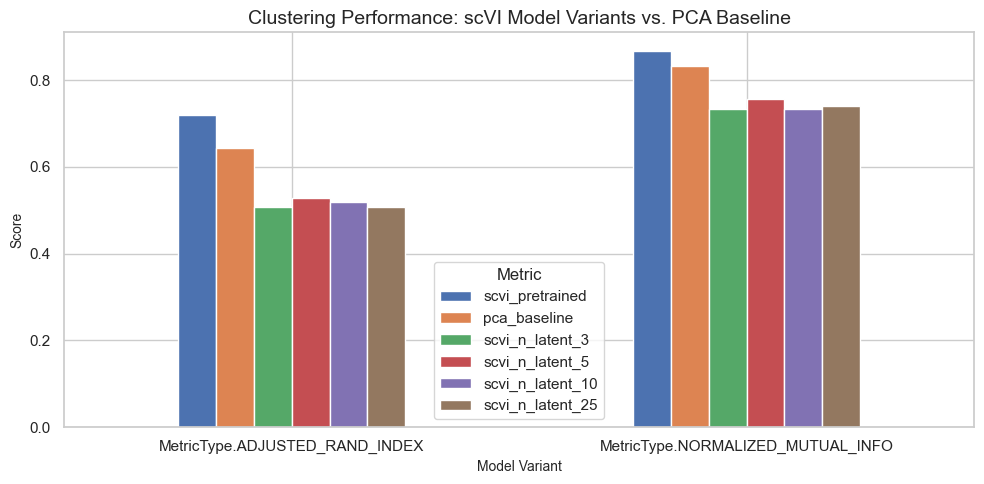

In [13]:
# Plot ARI and NMI for each model variant
results_df.plot.bar(figsize=(10, 5))
plt.title("Clustering Performance: scVI Model Variants vs. PCA Baseline", fontsize=14)
plt.ylabel("Score", fontsize=10)
plt.xlabel("Model Variant", fontsize=10)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()